# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '11'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedsnow"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2150090)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 17:34:22 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedsnow.values
    n_s  = xr.open_dataset(fname).n_rimedsnow.values
    r_s  = xr.open_dataset(fname).rime_rimedsnow.values
    v_s  = xr.open_dataset(fname).rvol_rimedsnow.values
    liq = xr.open_dataset(fname).liq_rimedsnow.values
    # process rates
    self_num  = xr.open_dataset(fname).self_rimedsnow.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    p_min = 1e-12
    # use liquid water fraction (no log transform for this)
    liq = np.where(q_s>q_min,liq/q_s,np.nan)  
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    self_num  = np.log(self_num,  where=self_num>p_min, out=np.nan*self_num)    
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, liq, temp, rho, self_num ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'liq', 'temp', 'rho', 'self_num' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s           n_s           r_s           v_s           liq  \
count  2.037858e+06  2.037858e+06  2.037858e+06  2.037858e+06  2.037858e+06   
mean  -5.432353e+00  3.376002e+00 -6.405976e+00 -1.239642e+01  1.743394e-01   
std    9.606463e-01  4.271795e+00  1.558084e+00  1.410896e+00  2.498873e-01   
min   -1.747787e+01 -1.380546e+01 -2.258566e+01 -2.761299e+01 -3.439975e+00   
25%   -5.969664e+00  1.448494e+00 -7.225443e+00 -1.305667e+01  0.000000e+00   
50%   -5.326778e+00  4.369637e+00 -6.221633e+00 -1.219765e+01  4.183129e-02   
75%   -4.784644e+00  5.759658e+00 -5.308166e+00 -1.147640e+01  2.560389e-01   
max   -3.506558e+00  1.430654e+01 -3.591136e+00 -8.925537e+00  9.962108e-01   

               temp           rho      self_num  
count  2.037858e+06  2.037858e+06  2.037858e+06  
mean   2.710539e+02  1.103587e+00 -2.876538e+00  
std    6.413640e+00  1.091651e-01  3.765218e+00  
min    2.457600e+02  7.110000e-01 -1.680119e+01  
25%    2.679100e+02  1.042000e+00 -4.497680e+00  
50%    2.733400e+02  1.126000e+00 -2.533001e+00  
75%    2.750900e+02  1.187000e+00 -4.573966e-01  
max    2.893600e+02  1.289000e+00  9.380252e+00

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s           liq        temp    rho  \
0 -8.190158  8.328547 -12.067076 -17.079985  4.633522e-08  265.890015  1.038   
4 -8.032917  8.313460  -9.967386 -14.986661  0.000000e+00  266.140015  1.042   
5 -8.001977  8.308913  -9.796159 -14.817060  0.000000e+00  266.209991  1.043   
6 -7.973852  8.304544  -9.659836 -14.682368  0.000000e+00  266.279999  1.044   
7 -7.948250  8.300231  -9.548180 -14.572386  0.000000e+00  266.339996  1.046   

   self_num  
0  0.564069  
4  0.616029  
5  0.575562  
6  0.568502  
7  0.369410

In [11]:
dataset_train.describe()

q_s           n_s           r_s           v_s           liq  \
count  1.425985e+06  1.425985e+06  1.425985e+06  1.425985e+06  1.425985e+06   
mean  -5.432278e+00  3.378835e+00 -6.405560e+00 -1.239599e+01  1.743404e-01   
std    9.601060e-01  4.271034e+00  1.557029e+00  1.409672e+00  2.498876e-01   
min   -1.594406e+01 -1.380546e+01 -2.258566e+01 -2.761299e+01 -3.439975e+00   
25%   -5.969351e+00  1.453860e+00 -7.224619e+00 -1.305648e+01  0.000000e+00   
50%   -5.327210e+00  4.371155e+00 -6.221532e+00 -1.219765e+01  4.180740e-02   
75%   -4.784536e+00  5.762712e+00 -5.308994e+00 -1.147727e+01  2.562437e-01   
max   -3.506624e+00  1.430654e+01 -3.591136e+00 -8.925537e+00  9.962108e-01   

               temp           rho      self_num  
count  1.425985e+06  1.425985e+06  1.425985e+06  
mean   2.710520e+02  1.103569e+00 -2.873284e+00  
std    6.414110e+00  1.091704e-01  3.764759e+00  
min    2.457600e+02  7.120000e-01 -1.680119e+01  
25%    2.679000e+02  1.042000e+00 -4.494891e+00  
50%    2.733400e+02  1.126000e+00 -2.528623e+00  
75%    2.750900e+02  1.187000e+00 -4.559445e-01  
max    2.893600e+02  1.288000e+00  9.380252e+00

In [12]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  305885.000000  305885.000000  305885.000000  305885.000000   
mean       -5.433697       3.373001      -6.408295     -12.398627   
std         0.962791       4.272350       1.560344       1.413903   
min       -13.618218     -13.541066     -22.293579     -27.459677   
25%        -5.970564       1.446589      -7.228828     -13.057044   
50%        -5.327849       4.367522      -6.224709     -12.199753   
75%        -4.785038       5.763780      -5.306672     -11.475822   
max        -3.506825      14.300280      -3.591281      -8.925688   

                 liq           temp            rho       self_num  
count  305885.000000  305885.000000  305885.000000  305885.000000  
mean        0.174575     271.063293       1.103613      -2.878362  
std         0.250126       6.409235       0.109053       3.766515  
min         0.000000     246.070007       0.711000     -16.801191  
25%         0.000000     267.940002       1.042000      -4.503833  
50%         0.042397     273.339996       1.126000      -2.529966  
75%         0.256072     275.100006       1.186000      -0.455033  
max         0.993441     289.140015       1.288000       8.968183

In [13]:
dataset_val.describe()

q_s            n_s            r_s            v_s  \
count  305988.000000  305988.000000  305988.000000  305988.000000   
mean       -5.431349       3.365796      -6.405595     -12.396237   
std         0.961019       4.274779       1.560734       1.413585   
min       -17.477865     -13.805461     -22.280727     -27.521540   
25%        -5.970329       1.426236      -7.226766     -13.057091   
50%        -5.323287       4.364982      -6.220173     -12.195617   
75%        -4.784751       5.740604      -5.306592     -11.472263   
max        -3.506558      14.304765      -3.591317      -8.926214   

                 liq           temp            rho       self_num  
count  305988.000000  305988.000000  305988.000000  305988.000000  
mean        0.174099     271.053894       1.103641      -2.889878  
std         0.249647       6.415870       0.109253       3.766041  
min         0.000000     246.149994       0.715000     -16.801191  
25%         0.000000     267.917511       1.042000      -4.503465  
50%         0.041420     273.339996       1.127000      -2.554438  
75%         0.255048     275.089996       1.187000      -0.464671  
max         0.994963     289.250000       1.289000       9.126941

### Further reduce data to relevant parameter range

In [17]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['liq'] < 0 ].index
    dataset.drop(idx,inplace=True)   
#    idx = dataset[ dataset['temp'] > 273 ].index
#    dataset.drop(idx,inplace=True)   
    return dataset

In [18]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
dataset_train.describe()

q_s           n_s           r_s           v_s           liq  \
count  1.425976e+06  1.425976e+06  1.425976e+06  1.425976e+06  1.425976e+06   
mean  -5.432275e+00  3.378931e+00 -6.405528e+00 -1.239596e+01  1.743555e-01   
std    9.601062e-01  4.270871e+00  1.556973e+00  1.409620e+00  2.497968e-01   
min   -1.594406e+01 -1.380546e+01 -2.258566e+01 -2.761299e+01  0.000000e+00   
25%   -5.969321e+00  1.454116e+00 -7.224581e+00 -1.305648e+01  0.000000e+00   
50%   -5.327210e+00  4.371168e+00 -6.221532e+00 -1.219763e+01  4.180850e-02   
75%   -4.784536e+00  5.762743e+00 -5.308994e+00 -1.147727e+01  2.562476e-01   
max   -3.506624e+00  1.430654e+01 -3.591136e+00 -8.925537e+00  9.962108e-01   

               temp           rho      self_num  
count  1.425976e+06  1.425976e+06  1.425976e+06  
mean   2.710519e+02  1.103569e+00 -2.873209e+00  
std    6.414111e+00  1.091706e-01  3.764654e+00  
min    2.457600e+02  7.120000e-01 -1.680119e+01  
25%    2.679000e+02  1.042000e+00 -4.494826e+00  
50%    2.733400e+02  1.126000e+00 -2.528588e+00  
75%    2.750900e+02  1.187000e+00 -4.559390e-01  
max    2.893600e+02  1.288000e+00  9.380252e+00

In [20]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  305885.000000  305885.000000  305885.000000  305885.000000   
mean       -5.433697       3.373001      -6.408295     -12.398627   
std         0.962791       4.272350       1.560344       1.413903   
min       -13.618218     -13.541066     -22.293579     -27.459677   
25%        -5.970564       1.446589      -7.228828     -13.057044   
50%        -5.327849       4.367522      -6.224709     -12.199753   
75%        -4.785038       5.763780      -5.306672     -11.475822   
max        -3.506825      14.300280      -3.591281      -8.925688   

                 liq           temp            rho       self_num  
count  305885.000000  305885.000000  305885.000000  305885.000000  
mean        0.174575     271.063293       1.103613      -2.878362  
std         0.250126       6.409235       0.109053       3.766515  
min         0.000000     246.070007       0.711000     -16.801191  
25%         0.000000     267.940002       1.042000      -4.503833  
50%         0.042397     273.339996       1.126000      -2.529966  
75%         0.256072     275.100006       1.186000      -0.455033  
max         0.993441     289.140015       1.288000       8.968183

### Pairplot

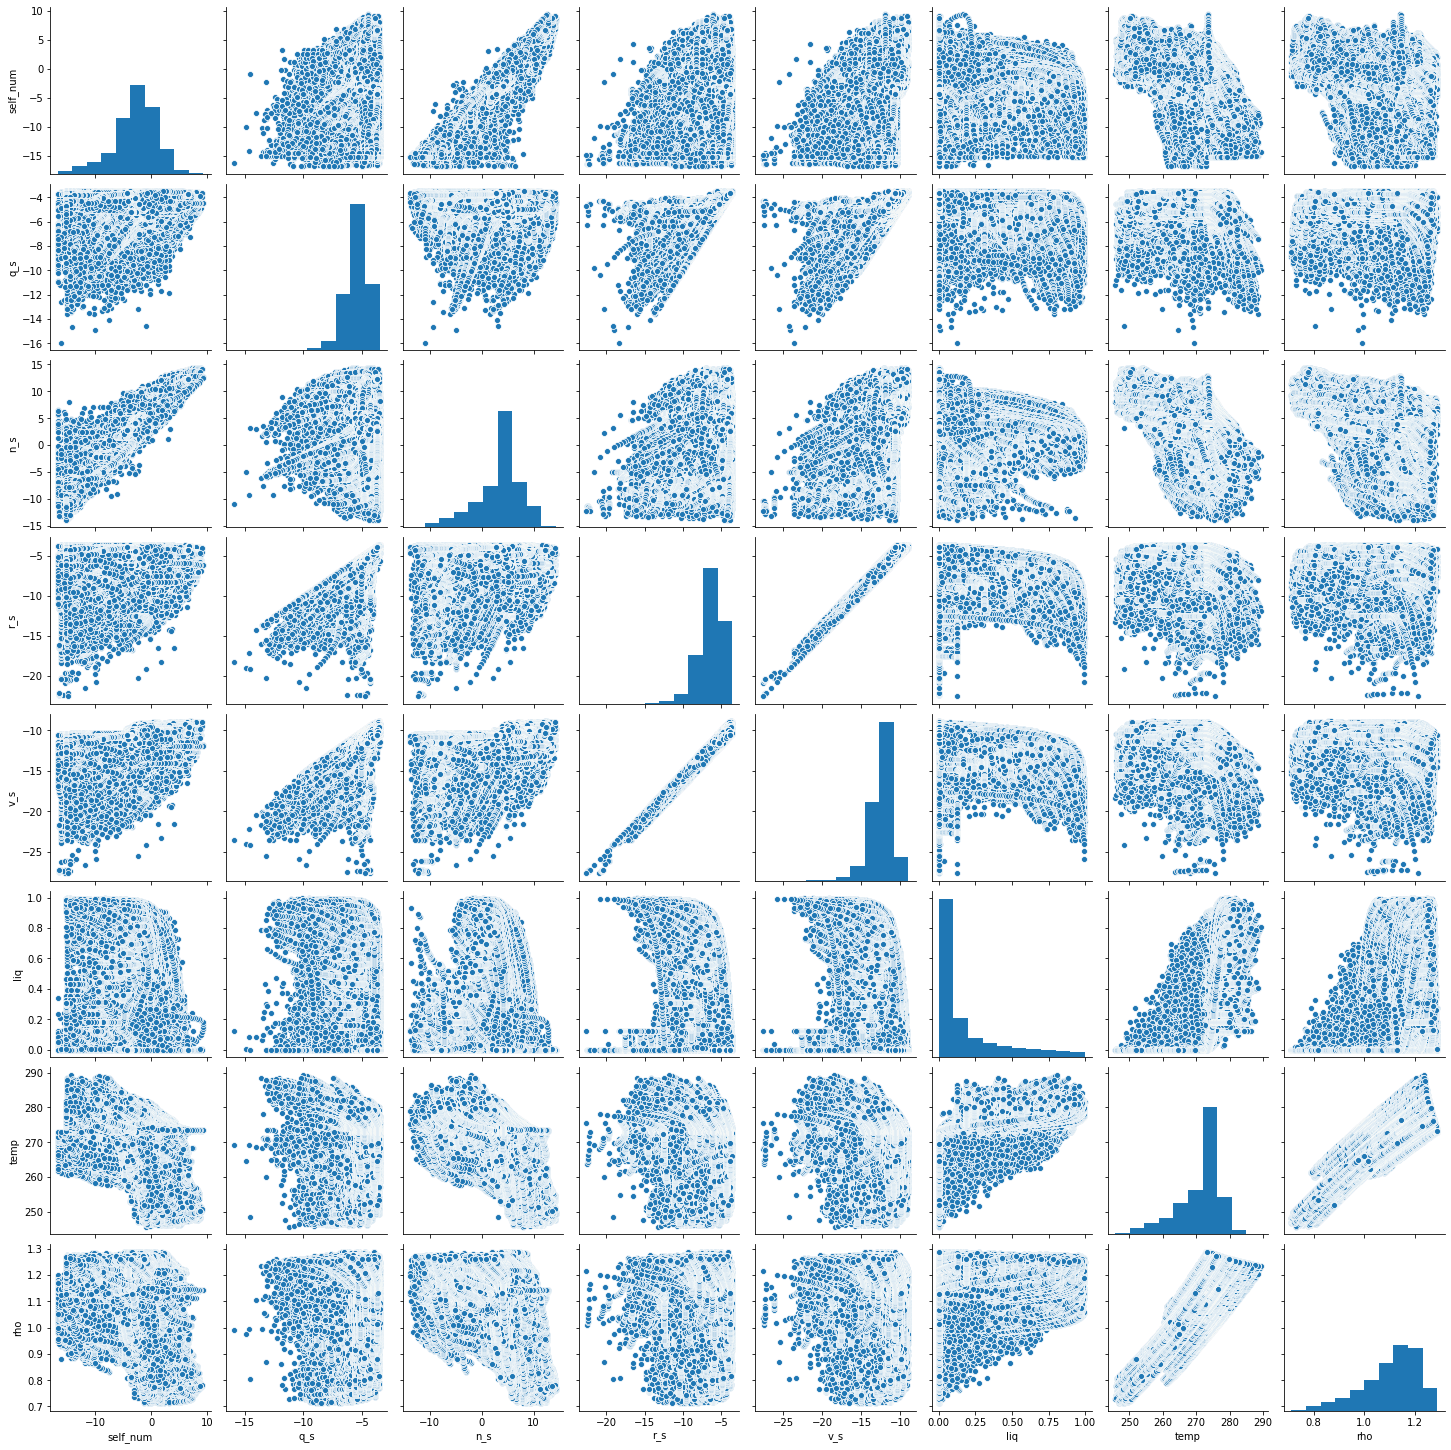

In [21]:
sns.pairplot(dataset_train[["self_num",'q_s','n_s','r_s','v_s','liq',"temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [22]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [23]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [24]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [25]:
train_dataset1 = train_dataset1.drop(['temp','rho','liq'], axis=1)
train_dataset2 = train_dataset2.drop(['liq'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [26]:
test_dataset1 = test_dataset1.drop(['temp','rho','liq'], axis=1)
test_dataset2 = test_dataset2.drop(['liq'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [27]:
val_dataset1 = val_dataset1.drop(['temp','rho','liq'], axis=1)
val_dataset2 = val_dataset2.drop(['liq'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [28]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("self_num")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  1425976.0  -5.432275  0.960106 -15.944058  -5.969321  -5.327210   
n_s  1425976.0   3.378931  4.270871 -13.805461   1.454116   4.371168   
r_s  1425976.0  -6.405528  1.556973 -22.585663  -7.224581  -6.221532   
v_s  1425976.0 -12.395963  1.409620 -27.612986 -13.056482 -12.197628   

           75%        max  
q_s  -4.784536  -3.506624  
n_s   5.762743  14.306541  
r_s  -5.308994  -3.591136  
v_s -11.477269  -8.925537

In [29]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("self_num")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_s   1425976.0   -5.432275  0.960106  -15.944058   -5.969321   -5.327210   
n_s   1425976.0    3.378931  4.270871  -13.805461    1.454116    4.371168   
r_s   1425976.0   -6.405528  1.556973  -22.585663   -7.224581   -6.221532   
v_s   1425976.0  -12.395963  1.409620  -27.612986  -13.056482  -12.197628   
temp  1425976.0  271.051910  6.414111  245.759995  267.899994  273.339996   
rho   1425976.0    1.103569  0.109171    0.712000    1.042000    1.126000   

             75%         max  
q_s    -4.784536   -3.506624  
n_s     5.762743   14.306541  
r_s    -5.308994   -3.591136  
v_s   -11.477269   -8.925537  
temp  275.089996  289.359985  
rho     1.187000    1.288000

In [30]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("self_num")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s   1425976.0   -5.432275  0.960106  -15.944058   -5.969321   -5.327210   
n_s   1425976.0    3.378931  4.270871  -13.805461    1.454116    4.371168   
r_s   1425976.0   -6.405528  1.556973  -22.585663   -7.224581   -6.221532   
v_s   1425976.0  -12.395963  1.409620  -27.612986  -13.056482  -12.197628   
liq   1425976.0    0.174355  0.249797    0.000000    0.000000    0.041809   
temp  1425976.0  271.051910  6.414111  245.759995  267.899994  273.339996   
rho   1425976.0    1.103569  0.109171    0.712000    1.042000    1.126000   

             75%         max  
q_s    -4.784536   -3.506624  
n_s     5.762743   14.306541  
r_s    -5.308994   -3.591136  
v_s   -11.477269   -8.925537  
liq     0.256248    0.996211  
temp  275.089996  289.359985  
rho     1.187000    1.288000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [31]:
# pop does not work for multiple columns, use copy instead

labels = ['self_num']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [32]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [33]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [34]:
train_labels.describe()

self_num
count  1.425976e+06
mean  -2.873209e+00
std    3.764654e+00
min   -1.680119e+01
25%   -4.494826e+00
50%   -2.528588e+00
75%   -4.559390e-01
max    9.380252e+00

In [35]:
train_dataset1.describe()

q_s           n_s           r_s           v_s
count  1.425976e+06  1.425976e+06  1.425976e+06  1.425976e+06
mean  -5.432275e+00  3.378931e+00 -6.405528e+00 -1.239596e+01
std    9.601062e-01  4.270871e+00  1.556973e+00  1.409620e+00
min   -1.594406e+01 -1.380546e+01 -2.258566e+01 -2.761299e+01
25%   -5.969321e+00  1.454116e+00 -7.224581e+00 -1.305648e+01
50%   -5.327210e+00  4.371168e+00 -6.221532e+00 -1.219763e+01
75%   -4.784536e+00  5.762743e+00 -5.308994e+00 -1.147727e+01
max   -3.506624e+00  1.430654e+01 -3.591136e+00 -8.925537e+00

In [36]:
train_dataset2.describe()

q_s           n_s           r_s           v_s          temp  \
count  1.425976e+06  1.425976e+06  1.425976e+06  1.425976e+06  1.425976e+06   
mean  -5.432275e+00  3.378931e+00 -6.405528e+00 -1.239596e+01  2.710519e+02   
std    9.601062e-01  4.270871e+00  1.556973e+00  1.409620e+00  6.414111e+00   
min   -1.594406e+01 -1.380546e+01 -2.258566e+01 -2.761299e+01  2.457600e+02   
25%   -5.969321e+00  1.454116e+00 -7.224581e+00 -1.305648e+01  2.679000e+02   
50%   -5.327210e+00  4.371168e+00 -6.221532e+00 -1.219763e+01  2.733400e+02   
75%   -4.784536e+00  5.762743e+00 -5.308994e+00 -1.147727e+01  2.750900e+02   
max   -3.506624e+00  1.430654e+01 -3.591136e+00 -8.925537e+00  2.893600e+02   

                rho  
count  1.425976e+06  
mean   1.103569e+00  
std    1.091706e-01  
min    7.120000e-01  
25%    1.042000e+00  
50%    1.126000e+00  
75%    1.187000e+00  
max    1.288000e+00

In [37]:
train_dataset3.describe()

q_s           n_s           r_s           v_s           liq  \
count  1.425976e+06  1.425976e+06  1.425976e+06  1.425976e+06  1.425976e+06   
mean  -5.432275e+00  3.378931e+00 -6.405528e+00 -1.239596e+01  1.743555e-01   
std    9.601062e-01  4.270871e+00  1.556973e+00  1.409620e+00  2.497968e-01   
min   -1.594406e+01 -1.380546e+01 -2.258566e+01 -2.761299e+01  0.000000e+00   
25%   -5.969321e+00  1.454116e+00 -7.224581e+00 -1.305648e+01  0.000000e+00   
50%   -5.327210e+00  4.371168e+00 -6.221532e+00 -1.219763e+01  4.180850e-02   
75%   -4.784536e+00  5.762743e+00 -5.308994e+00 -1.147727e+01  2.562476e-01   
max   -3.506624e+00  1.430654e+01 -3.591136e+00 -8.925537e+00  9.962108e-01   

               temp           rho  
count  1.425976e+06  1.425976e+06  
mean   2.710519e+02  1.103569e+00  
std    6.414111e+00  1.091706e-01  
min    2.457600e+02  7.120000e-01  
25%    2.679000e+02  1.042000e+00  
50%    2.733400e+02  1.126000e+00  
75%    2.750900e+02  1.187000e+00  
max    2.893600e+02  1.288000e+00

### Normalize the features

In [38]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [39]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std        min       25%       50%       75%  \
q_s  1425976.0  4.721076e-07  1.0 -10.948563 -0.559361  0.109430  0.674653   
n_s  1425976.0  2.681518e-07  1.0  -4.023627 -0.450684  0.232327  0.558156   
r_s  1425976.0 -4.357070e-07  1.0 -10.392045 -0.526055  0.118176  0.704273   
v_s  1425976.0  1.574237e-06  1.0 -10.795126 -0.468580  0.140701  0.651731   

          max  
q_s  2.005664  
n_s  2.558637  
r_s  1.807605  
v_s  2.461959

In [40]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std        min       25%       50%       75%  \
q_s   1425976.0  4.721076e-07  1.0 -10.948563 -0.559361  0.109430  0.674653   
n_s   1425976.0  2.681518e-07  1.0  -4.023627 -0.450684  0.232327  0.558156   
r_s   1425976.0 -4.357070e-07  1.0 -10.392045 -0.526055  0.118176  0.704273   
v_s   1425976.0  1.574237e-06  1.0 -10.795126 -0.468580  0.140701  0.651731   
temp  1425976.0  1.313936e-05  1.0  -3.943168 -0.491403  0.356727  0.629563   
rho   1425976.0 -1.421528e-07  1.0  -3.586762 -0.563970  0.205468  0.764226   

           max  
q_s   2.005664  
n_s   2.558637  
r_s   1.807605  
v_s   2.461959  
temp  2.854343  
rho   1.689383

In [41]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std        min       25%       50%       75%  \
q_s   1425976.0  4.721076e-07  1.0 -10.948563 -0.559361  0.109430  0.674653   
n_s   1425976.0  2.681518e-07  1.0  -4.023627 -0.450684  0.232327  0.558156   
r_s   1425976.0 -4.357070e-07  1.0 -10.392045 -0.526055  0.118176  0.704273   
v_s   1425976.0  1.574237e-06  1.0 -10.795126 -0.468580  0.140701  0.651731   
liq   1425976.0  1.199888e-07  1.0  -0.697989 -0.697989 -0.530619  0.327835   
temp  1425976.0  1.313936e-05  1.0  -3.943168 -0.491403  0.356727  0.629563   
rho   1425976.0 -1.421528e-07  1.0  -3.586762 -0.563970  0.205468  0.764226   

           max  
q_s   2.005664  
n_s   2.558637  
r_s   1.807605  
v_s   2.461959  
liq   3.290095  
temp  2.854343  
rho   1.689383

### Normalize the labels

In [42]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std        min       25%       50%  \
self_num  1425976.0 -2.873209  3.764654 -16.801191 -4.494826 -2.528588   

               75%       max  
self_num -0.455939  9.380252

In [43]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [44]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [45]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [47]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8069029 ],
       [-0.8173486 ],
       [-0.8185747 ],
       [-0.8196002 ],
       [-0.8204733 ],
       [-0.8212139 ],
       [-0.82185674],
       [-0.82241577],
       [-0.8228996 ],
       [-0.82367367]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [48]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [49]:
activ = "ReLU"
model1 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0460,  mae:0.1427,  mse:0.0460,  val_loss:0.0401,  val_mae:0.1318,  val_mse:0.0401,  
................................................

In [50]:
histories['ReLU'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.2])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [51]:
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0322,  mae:0.1198,  mse:0.0322,  val_loss:0.0234,  val_mae:0.1000,  val_mse:0.0234,  
...............................................................

Text(0, 0.5, 'MAE')

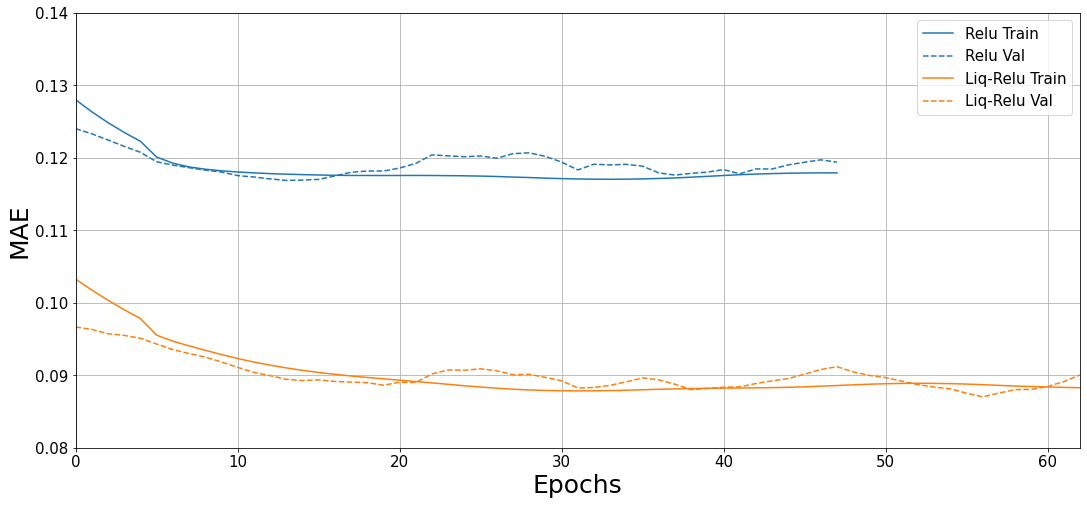

In [52]:
histories['liq-ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.08, 0.14])
plt.ylabel('MAE')

In [53]:
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0481,  mae:0.1475,  mse:0.0481,  val_loss:0.0383,  val_mae:0.1274,  val_mse:0.0383,  
.............................................................

Text(0, 0.5, 'MAE')

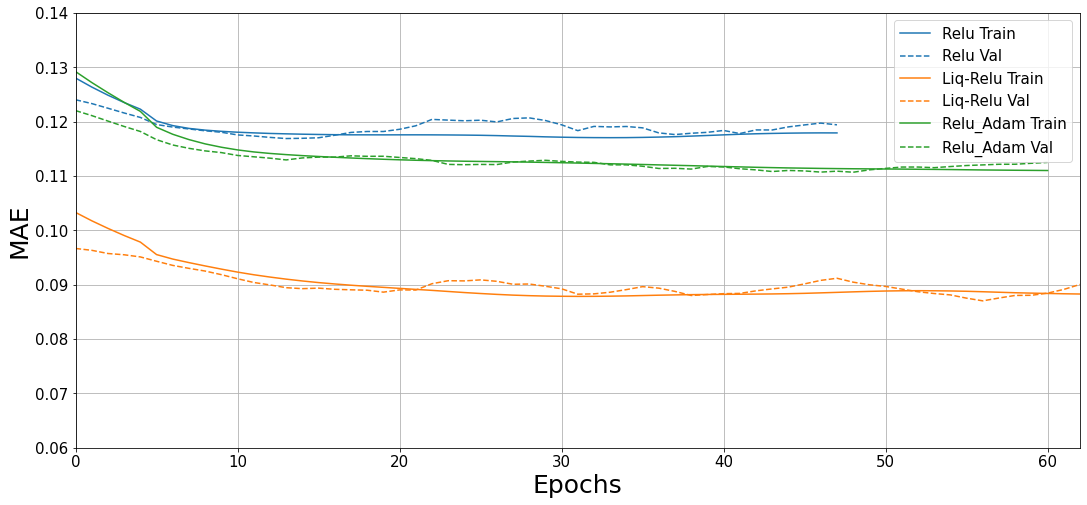

In [54]:
histories['ReLU_Adam'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.14])
plt.ylabel('MAE')

In [55]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0323,  mae:0.1209,  mse:0.0323,  val_loss:0.0235,  val_mae:0.1000,  val_mse:0.0235,  
...........................................

Text(0, 0.5, 'MAE')

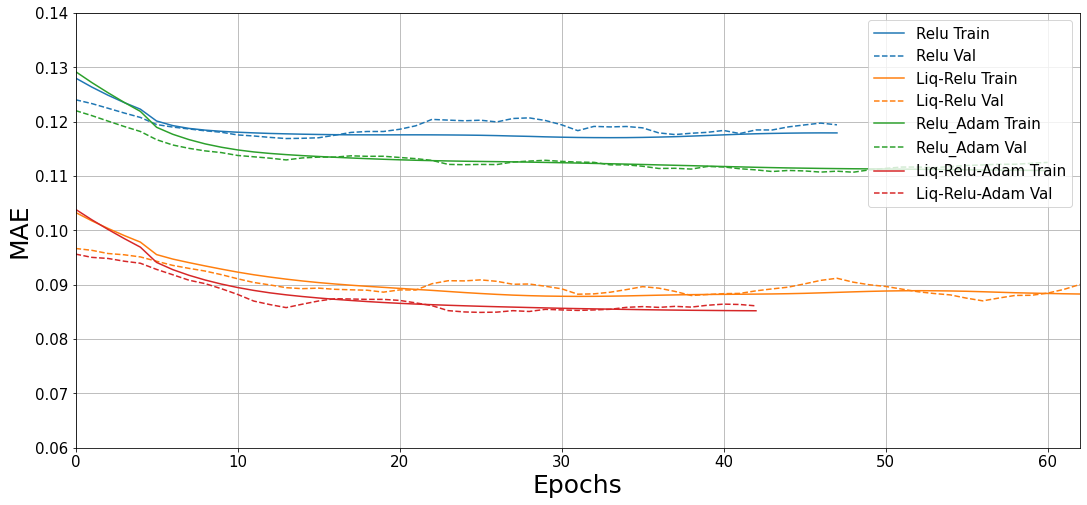

In [56]:
histories['liq-ReLU-Adam'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.14])
plt.ylabel('MAE')

In [57]:
nsize = 32
activ = "ReLU_Adam"
model5 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0278,  mae:0.1106,  mse:0.0278,  val_loss:0.0201,  val_mae:0.0902,  val_mse:0.0201,  
...........................................

Text(0, 0.5, 'MAE')

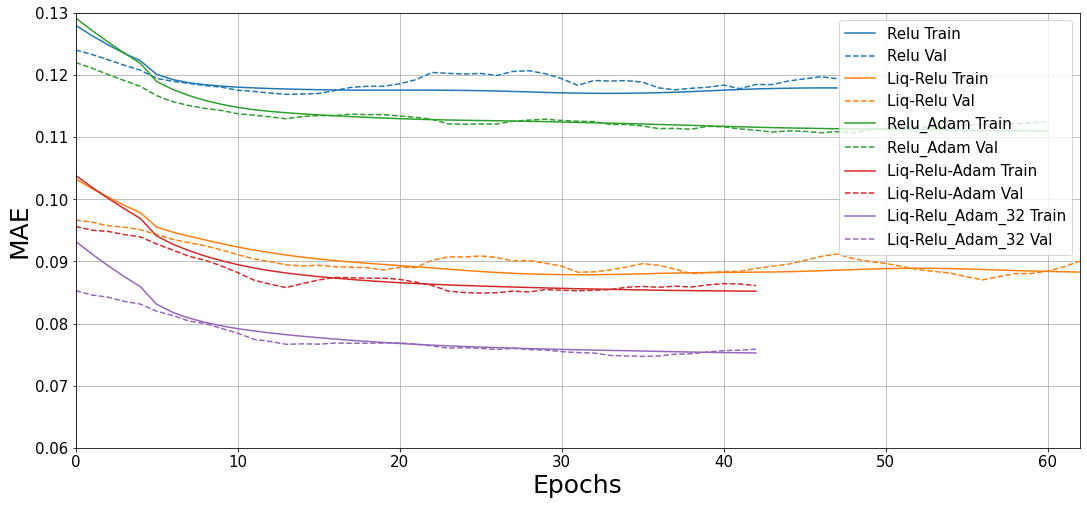

In [58]:
histories['liq-ReLU_Adam_32'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.06, 0.13])
plt.ylabel('MAE')

In [60]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.01, 0.05])
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

In [61]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

305885/305885 - 7s - loss: 0.0339 - mae: 0.1134 - mse: 0.0339
Testing set for model 1, Mean Abs Error:    0.11337


In [62]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

305885/305885 - 7s - loss: 0.0182 - mae: 0.0832 - mse: 0.0182
Testing set for model 2, Mean Abs Error:              0.08320


In [63]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

305885/305885 - 7s - loss: 0.0320 - mae: 0.1106 - mse: 0.0320
Testing set for model 3, Mean Abs Error:              0.11057


In [64]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

305885/305885 - 7s - loss: 0.0177 - mae: 0.0829 - mse: 0.0177
Testing set for model 4, Mean Abs Error:              0.08292


In [65]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

305885/305885 - 7s - loss: 0.0149 - mae: 0.0738 - mse: 0.0149
Testing set for model 5, Mean Abs Error:              0.07375


In [66]:
mae = [ mae1, mae2, mae3, mae4, mae5 ]
mae

[0.113367945, 0.08319578, 0.1105742, 0.082919076, 0.07375134]

In [67]:
mse = [ mse1, mse2, mse3, mse4, mse5 ]
mse

[0.033915967, 0.018174816, 0.031987507, 0.017650643, 0.014931629]

In [68]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1 \n ReLU',
 'model 2 \n ReLU',
 'model 3 \n ReLU_Adam',
 'model 4 \n ReLU_Adam',
 'model 5 \n ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized self_num')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [69]:
test_true_self_snow_num  = np.exp(test_labels.pop('self_num'))

In [70]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [71]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data2), columns=["self_num"])

In [72]:
p1.describe()

self_num
count  305885.000000
mean        0.002785
std         0.973095
min        -4.173906
25%        -0.375145
50%         0.078530
75%         0.619153
max         3.143892

In [73]:
train_labels_stats

count      mean       std        min       25%       50%  \
self_num  1425976.0 -2.873209  3.764654 -16.801191 -4.494826 -2.528588   

               75%       max  
self_num -0.455939  9.380252

In [74]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [75]:
test_predict1.describe()

self_num
count  3.058850e+05
mean   4.589028e+00
std    6.049696e+01
min    8.471807e-09
25%    1.376671e-02
50%    7.595837e-02
75%    5.814027e-01
max    7.804490e+03

In [76]:
test_predict1_self_snow_num  = test_predict1['self_num']

In [77]:

p2 = pd.DataFrame(data=model4.predict(normed_test_data3), columns=["self_num"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_self_snow_num  = test_predict2['self_num']

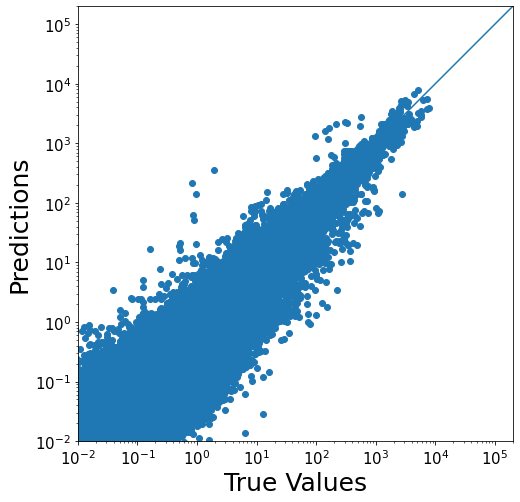

In [78]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-2, 2e5

a = plt.axes(aspect='equal')
plt.scatter(test_true_self_snow_num, test_predict1_self_snow_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

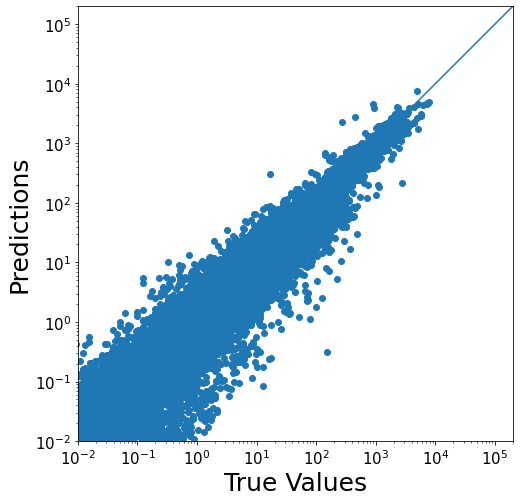

In [79]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

a = plt.axes(aspect='equal')
plt.scatter(test_true_self_snow_num, test_predict2_self_snow_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [80]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2

In [81]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [82]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, T, rho'
labels   = 'self_rimedsnow_num'
filename = 'saved_model_v2/self_rimedsnow_model1_'+version+'.nc'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)
save2netcdf(model1,features,labels,train_stats2,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/self_rimedsnow_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats2,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/self_rimedsnow_model1_11.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, T, rho
  Labels:     self_rimedsnow_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/self_rimedsnow_model3_11.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, T, rho
  Labels:     self_rimedsnow_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 't

In [83]:
features = 'q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, T, rho'
filename = 'saved_model_v2/self_rimedsnow_model2_'+version+'.nc'
logtransform = np.array([True, True, True, True, False, False, False], dtype=bool)
save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/self_rimedsnow_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/self_rimedsnow_model5_'+version+'.nc'
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/self_rimedsnow_model2_11.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, T, rho
  Labels:     self_rimedsnow_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/self_rimedsnow_model4_11.nc
  Features:   q_rimedsnow, n_rimedsnow, rmass_rimedsnow, rvol_rimedsnow, liqfrac, T, rho
  Labels:     self_rimedsnow_num
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  